In [ ]:
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import CategoricalCrossentropy
import ast  

# Load Model 1
model_1 = load_model('stage_1_model.h5')

# File path for logging
csv_file = 'satellite_predictions_per_timestep.csv'

# If the file does not exist, create it with headers
if not os.path.exists(csv_file):
    pd.DataFrame(columns=['timestamp', 'satellite', 'predicted_gateways']).to_csv(csv_file, index=False)

# Function to generate filenames
def generate_time_file_names(start_time_str, end_time_str, folder_path, prefix='optimal_file_data_'):
    start_time = datetime.strptime(start_time_str, '%H_%M_%S')
    end_time = datetime.strptime(end_time_str, '%H_%M_%S')
    current_time = start_time
    while current_time <= end_time:
        time_str = current_time.strftime('%H_%M_%S')
        file_name = f"{prefix}{time_str}.csv"
        yield os.path.join(folder_path, file_name)
        current_time += timedelta(seconds=20)

# Function to process each file
def process_file(file_name):
    if not os.path.exists(file_name):
        return None, None, None, None, None

    timestamp = file_name.split('_')[-1].replace('.csv', '')  # Extract timestamp

    optimal_data = pd.read_csv(file_name, usecols=['feed_sat', 'Latitude', 'Longitude', 'Altitude', 'optimal_gateway_matrix'])
    optimal_data.drop_duplicates(subset=['feed_sat'], inplace=True)

    if optimal_data.empty:
        return None, None, None, None, None  # Skip empty files

    optimal_data[['Latitude', 'Longitude', 'Altitude']] = optimal_data[['Latitude', 'Longitude', 'Altitude']].astype(float)

    sat_positions = {feed_sat: np.array([lat, lon, alt], dtype=np.float32) 
                     for feed_sat, lat, lon, alt in zip(optimal_data['feed_sat'], 
                                                        optimal_data['Latitude'], 
                                                        optimal_data['Longitude'], 
                                                        optimal_data['Altitude'])}

    optimal_data['optimal_gateway_matrix'] = optimal_data['optimal_gateway_matrix'].apply(lambda x: np.array(ast.literal_eval(x), dtype=np.float32))
    sat_labels = dict(zip(optimal_data['feed_sat'], optimal_data['optimal_gateway_matrix']))
    
    sat_list = list(sat_positions.keys())

    if not sat_positions:
        return None, None, None, None, None  # Skip empty datasets

    X_input = np.array(list(sat_positions.values()), dtype=np.float32)

    if X_input.shape[1] == 3:
        X_input = np.hstack([X_input, np.zeros((X_input.shape[0], 1))])

    top_3_preds = get_top_3_predictions(model_1, X_input)
    sat_top_3_map = {sat: pred for sat, pred in zip(sat_list, top_3_preds)}

    sat_neighbors = {}
    for sat, pos in sat_positions.items():
        distances = [(other_sat, np.linalg.norm(pos - sat_positions[other_sat])) 
                     for other_sat in sat_list if other_sat != sat]
        nearest_neighbors = sorted(distances, key=lambda x: x[1])[:4]
        sat_neighbors[sat] = [sat_positions[n[0]] for n in nearest_neighbors]

    return sat_positions, sat_neighbors, sat_top_3_map, sat_labels, timestamp

# Function to get top-3 predictions
def get_top_3_predictions(model, X):
    predictions = model.predict(X, batch_size=256, verbose=0)
    top_3_indices = np.argsort(predictions, axis=1)[:, -3:]
    top_3_probs = np.take_along_axis(predictions, top_3_indices, axis=1)
    return np.hstack((top_3_indices, top_3_probs))

# Training settings
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Files with position"
train_files = list(generate_time_file_names('16_00_00', '19_00_00', folder_path))
test_files = list(generate_time_file_names('19_00_00', '20_30_00', folder_path))

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Set mode flag to track whether training or testing is being processed
processing_mode = None  

X_train, y_train = [], []
batch_predictions = []  # Store batch results before writing

# Process training data
if processing_mode != "TRAINING":
    print("\n Processing Training Files...\n")
    processing_mode = "TRAINING"

for i, file_name in enumerate(train_files):
    sat_positions, sat_neighbors, sat_top_3_map, sat_labels, timestamp = process_file(file_name)
    if sat_positions is None:
        continue  

    for sat in sat_positions.keys():
        sat_pos = sat_positions[sat]
        neighbor_pos = sat_neighbors[sat]
        top_3_preds = sat_top_3_map[sat]
        y_label = sat_labels[sat]

        feature_vector = np.concatenate([sat_pos] + neighbor_pos + [top_3_preds])
        X_train.append(feature_vector)
        y_train.append(y_label)

        batch_predictions.append({'timestamp': timestamp, 'satellite': sat, 'predicted_gateways': top_3_preds.tolist()})

    if i % 50 == 0 and batch_predictions:
        df_predictions = pd.DataFrame(batch_predictions)
        df_predictions.to_csv(csv_file, mode='a', header=False, index=False)
        batch_predictions = []  

if batch_predictions:
    df_predictions = pd.DataFrame(batch_predictions)
    df_predictions.to_csv(csv_file, mode='a', header=False, index=False)

X_train = np.array(X_train)
y_train = np.vstack(y_train)

# Ensure Scaler is Fitted on 21 Features
assert X_train.shape[1] == 21, "Training data should have 21 features!"
scaler.fit(X_train)
X_train = scaler.transform(X_train)

# Process testing data
if processing_mode != "TESTING":
    print("\n Processing Testing Files...\n")
    processing_mode = "TESTING"

X_test, y_test = [], []
for file_name in test_files:
    sat_positions, sat_neighbors, sat_top_3_map, sat_labels, timestamp = process_file(file_name)
    if sat_positions is None:
        continue  

    for sat in sat_positions.keys():
        sat_pos = sat_positions[sat]
        neighbor_pos = sat_neighbors[sat]
        top_3_preds = sat_top_3_map[sat]
        y_label = sat_labels[sat]

        feature_vector = np.concatenate([sat_pos] + neighbor_pos + [top_3_preds])
        X_test.append(feature_vector)
        y_test.append(y_label)

X_test = np.array(X_test)
y_test = np.vstack(y_test)

# Ensure Test Data Has 21 Features Before Scaling
assert X_test.shape[1] == 21, f"Test data should have 21 features but has {X_test.shape[1]}!"
X_test = scaler.transform(X_test)

# Define Model 2
model_2 = Sequential([
    Dense(256, kernel_regularizer='l2'),
    LeakyReLU(alpha=0.05),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, kernel_regularizer='l2'),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, kernel_regularizer='l2'),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.3),

    Dense(y_train.shape[1], activation='softmax')  # Multi-class classification (One-hot output)
])

# Compile Model 2
optimizer = RMSprop(learning_rate=0.0005, rho=0.9)
model_2.compile(optimizer=optimizer, 
                loss=CategoricalCrossentropy(label_smoothing=0.1), 
                metrics=['accuracy'])

# Train Model 2
history = model_2.fit(
    X_train, y_train,
    epochs=50,
    batch_size=256,
    validation_data=(X_test, y_test),  
    verbose=1
)

# Save Model
model_2.save('stage_2_neigh_model.h5')

print("\n Model training and satellite predictions saved efficiently!")



🟢 Processing Training Files...


🔵 Processing Testing Files...

Epoch 1/50


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


233/233 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.1690 - loss: 5.7404 - val_accuracy: 0.0343 - val_loss: 4.8727
Epoch 2/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2890 - loss: 3.3925 - val_accuracy: 0.0660 - val_loss: 4.1328
Epoch 3/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3272 - loss: 2.8352 - val_accuracy: 0.2311 - val_loss: 3.0947
Epoch 4/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3495 - loss: 2.6192 - val_accuracy: 0.2861 - val_loss: 2.7231
Epoch 5/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3635 - loss: 2.5032 - val_accuracy: 0.4043 - val_loss: 2.3305
Epoch 6/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3783 - loss: 2.4362 - val_accuracy: 0.3880 - val_loss: 2.4097
Epoch 7/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3829 - loss: 2.3987 - val_accuracy: 0.4104 - val_loss: 2.2821
Epoch 8/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3889 - loss: 2.3640 - val_accuracy: 0.438


✅ Model training and satellite predictions saved efficiently!


In [2]:
# Evaluation
train_loss, train_accuracy = model_2.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = model_2.evaluate(X_test, y_test, verbose=0)

print(f"\nTraining Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Compute Top-K Accuracy
def compute_top_k_accuracy(model, X_test, y_test, k_values=[1, 3, 5]):
    predictions = model.predict(X_test)
    top_k_indices = {k: np.argsort(predictions, axis=1)[:, -k:] for k in k_values}
    y_true = np.argmax(y_test, axis=1)
    top_k_accuracies = {k: np.mean(np.any(top_k_indices[k] == y_true[:, None], axis=1)) * 100 for k in k_values}
    return top_k_accuracies

top_k_accuracies = compute_top_k_accuracy(model_2, X_test, y_test, k_values=[1, 3, 5])
print("\nTop-K Accuracy Results:")
for k, acc in top_k_accuracies.items():
    print(f"Top-{k} Accuracy: {acc:.2f}%")

import pickle

# Save scaler for Model 2
with open('stage_2_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)


Training Loss: 2.0916, Training Accuracy: 0.4517
Test Loss: 2.0981, Test Accuracy: 0.4532
934/934 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Top-K Accuracy Results:
Top-1 Accuracy: 45.32%
Top-3 Accuracy: 76.65%
Top-5 Accuracy: 87.86%


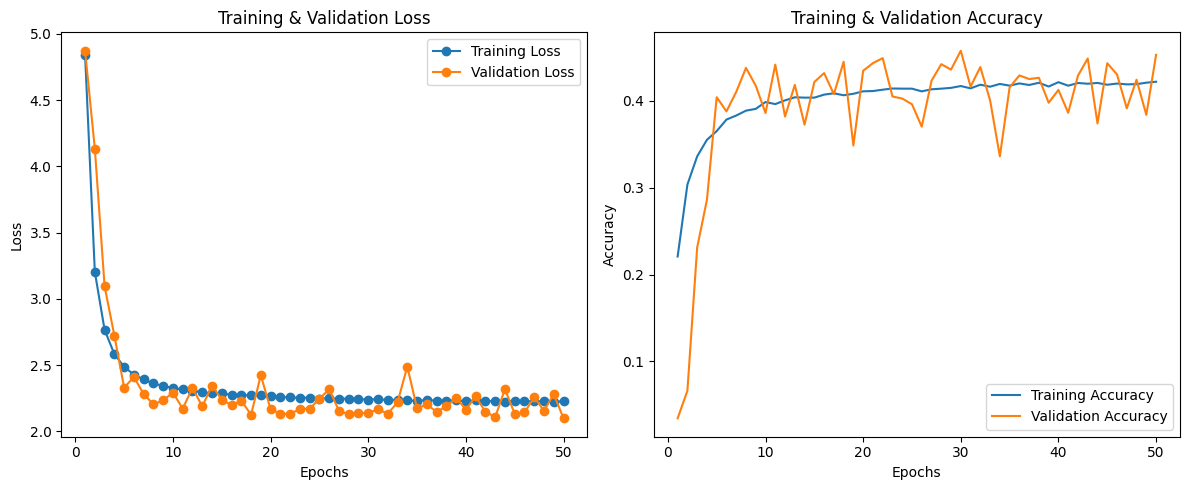

In [4]:
import matplotlib.pyplot as plt

# Extract values from training history
epochs = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(12, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], label='Training Loss', marker='o')

# Plot Validation Loss if available
if 'val_loss' in history.history:
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot Training Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')

# Plot Validation Accuracy if available
if 'val_accuracy' in history.history:
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()



Testing model 2

In [22]:
import os
import numpy as np
import pandas as pd
import joblib
import ast
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# Load Model 2
model_2 = load_model('stage_2_neigh_model.h5')  # Ensure correct model path
scaler = joblib.load('stage_2_scaler.pkl')  # Load the same scaler used for training

# File Path
file_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Files with position\optimal_file_data_00_01_20.csv"

# Load Test File
df = pd.read_csv(file_path, usecols=['feed_sat', 'Latitude', 'Longitude', 'Altitude', 'optimal_gateway_matrix', 'gw'])

def parse_gateway_matrix(matrix_str):
    try:
        return np.array(ast.literal_eval(matrix_str), dtype=np.float32)
    except:
        return None

df['optimal_gateway_matrix'] = df['optimal_gateway_matrix'].apply(parse_gateway_matrix)
df.dropna(subset=['optimal_gateway_matrix'], inplace=True)

# Extract Features (Satellite Position + Neighboring Info)
X_test = []
sat_positions = {sat: np.array([lat, lon, alt], dtype=np.float32) 
                 for sat, lat, lon, alt in zip(df['feed_sat'], df['Latitude'], df['Longitude'], df['Altitude'])}

sat_neighbors = {}
for sat, pos in sat_positions.items():
    distances = [(other_sat, np.linalg.norm(pos - sat_positions[other_sat])) 
                 for other_sat in sat_positions if other_sat != sat]
    nearest_neighbors = sorted(distances, key=lambda x: x[1])[:4]  # Get 4 closest neighbors
    sat_neighbors[sat] = [sat_positions[n[0]] for n in nearest_neighbors]

for sat in df['feed_sat']:
    if sat in sat_positions and sat in sat_neighbors:
        sat_pos = sat_positions[sat]
        neighbor_pos = sat_neighbors[sat]
        top_3_preds = np.zeros(6)  # Placeholder for model_1 predictions (use real predictions if available)
        feature_vector = np.concatenate([sat_pos] + neighbor_pos + [top_3_preds])
        X_test.append(feature_vector)

X_test = np.array(X_test, dtype=np.float32)
X_test = scaler.transform(X_test)  # Normalize Features

# Get Predictions from Model 2
predictions = model_2.predict(X_test)

# Get Top 3 Gateway Predictions
top_3_predictions = np.argsort(predictions, axis=1)[:, -3:][:, ::-1]  # Get top 3 indices sorted by confidence

# Get Top 1 Gateway Prediction
top_1_predictions = np.argmax(predictions, axis=1)

# Combine into a DataFrame
output_df = pd.DataFrame({
    'Satellite': df['feed_sat'].values,
    'Predicted Gateway': top_1_predictions,
    
    'Actual Gateway': df['gw'].values
})

# Save to CSV for reference
output_df.to_csv("model_2_predictions.csv", index=False)

# Display first few rows
print(output_df.head())


143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
   Satellite  Predicted Gateway  Actual Gateway
0        416                 22              20
1        484                 42              53
2        165                  5               5
3        166                 30              30
4        415                 45              36


Merged Model

In [27]:
import os
import numpy as np
import pandas as pd
import joblib
import ast
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# Load Models
model_1 = load_model('stage_1_model.h5')
scaler_1 = joblib.load('stage_1_scaler.pkl')
model_2 = load_model('stage_2_neigh_model.h5')
scaler_2 = joblib.load('stage_2_scaler.pkl')

# File Path
file_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Files with position\optimal_file_data_00_01_20.csv"

# Load File
df = pd.read_csv(file_path, usecols=['feed_sat', 'Latitude', 'Longitude', 'Altitude', 'optimal_gateway_matrix', 'gw'])

def parse_gateway_matrix(matrix_str):
    try:
        return np.array(ast.literal_eval(matrix_str), dtype=np.float32)
    except:
        return None

df['optimal_gateway_matrix'] = df['optimal_gateway_matrix'].apply(parse_gateway_matrix)
df.dropna(subset=['optimal_gateway_matrix'], inplace=True)

# Model 1 Processing
X_test_1 = df[['feed_sat', 'Latitude', 'Longitude', 'Altitude']].values  # Ensure 4 features
X_test_1 = scaler_1.transform(X_test_1)  # Now it matches the scaler training shape

actual_gateway = df['gw'].values
predictions_1 = model_1.predict(X_test_1)
top_3_predictions_1 = np.argsort(predictions_1, axis=1)[:, -3:][:, ::-1]
top_1_predictions_1 = np.argmax(predictions_1, axis=1)

# Model 2 Processing
X_test_2 = []
sat_positions = {sat: np.array([lat, lon, alt], dtype=np.float32) 
                 for sat, lat, lon, alt in zip(df['feed_sat'], df['Latitude'], df['Longitude'], df['Altitude'])}

sat_neighbors = {}
for sat, pos in sat_positions.items():
    distances = [(other_sat, np.linalg.norm(pos - sat_positions[other_sat])) 
                 for other_sat in sat_positions if other_sat != sat]
    nearest_neighbors = sorted(distances, key=lambda x: x[1])[:4]
    sat_neighbors[sat] = [sat_positions[n[0]] for n in nearest_neighbors]

for sat in df['feed_sat']:
    if sat in sat_positions and sat in sat_neighbors:
        sat_pos = sat_positions[sat]
        neighbor_pos = sat_neighbors[sat]
        idx = df.index[df['feed_sat'] == sat].tolist()[0]
        top_3_indices = np.argsort(predictions_1[idx])[-3:][::-1]
        top_3_probs = predictions_1[idx, top_3_indices]
        top_3_preds = np.concatenate([top_3_indices, top_3_probs])  # Ensuring 6 features
        feature_vector = np.concatenate([sat_pos] + neighbor_pos + [top_3_preds])
        X_test_2.append(feature_vector)

X_test_2 = np.array(X_test_2, dtype=np.float32)
X_test_2 = scaler_2.transform(X_test_2)
predictions_2 = model_2.predict(X_test_2)
top_3_predictions_2 = np.argsort(predictions_2, axis=1)[:, -3:][:, ::-1]
top_1_predictions_2 = np.argmax(predictions_2, axis=1)

# Compute Accuracy
unique_sats = df['feed_sat'].nunique()
correct_1 = sum(top_1_predictions_1 == df['gw'].values)
accuracy_1 = (correct_1 / unique_sats) * 100

correct_2 = sum(top_1_predictions_2 == df['gw'].values)
accuracy_2 = (correct_2 / unique_sats) * 100

# Combine into DataFrame
output_df = pd.DataFrame({
    'Satellite': df['feed_sat'].values,
    'Predicted Gateway Model 1': top_1_predictions_1,
    'Predicted 3 Gateways Model 1': [list(map(int, row)) for row in top_3_predictions_1],
    'Predicted Gateway Model 2': top_1_predictions_2,
    'Predicted 3 Gateways Model 2': [list(map(int, row)) for row in top_3_predictions_2],
    'Actual Gateway': actual_gateway
})

# Save to CSV
output_df.to_csv("merged_model_predictions.csv", index=False)

# Display Results
print(output_df.head())
print(f"Model 1 Accuracy: {accuracy_1:.2f}%")
print(f"Model 2 Accuracy: {accuracy_2:.2f}%")


143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
   Satellite  Predicted Gateway Model 1 Predicted 3 Gateways Model 1  \
0        416                         25                 [25, 22, 47]   
1        484                         42                  [42, 17, 0]   
2        165                          8                    [8, 9, 3]   
3        166                         31                 [31, 30, 19]   
4        415                         45                 [45, 44, 36]   

   Predicted Gateway Model 2 Predicted 3 Gateways Model 2  Actual Gateway  
0                         22                 [22, 25, 47]              20  
1                         42                 [42, 17, 37]              53  
2                          5                   [5, 9, 43]               5  
3                         30                 [30, 31, 19]              30  
4                         45                 [45, 44, 36]              36  
Model 1 Accuracy: 1259.43%
Mo

In [29]:
import os
import numpy as np
import pandas as pd
import joblib
import ast
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# Load Models
model_1 = load_model('stage_1_model.h5')
scaler_1 = joblib.load('stage_1_scaler.pkl')
model_2 = load_model('stage_2_neigh_model.h5')
scaler_2 = joblib.load('stage_2_scaler.pkl')

# File Path
file_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Files with position\optimal_file_data_00_01_20.csv"

# Load File
df = pd.read_csv(file_path, usecols=['feed_sat', 'Latitude', 'Longitude', 'Altitude', 'optimal_gateway_matrix', 'gw'])

def parse_gateway_matrix(matrix_str):
    try:
        return np.array(ast.literal_eval(matrix_str), dtype=np.float32)
    except:
        return None

df['optimal_gateway_matrix'] = df['optimal_gateway_matrix'].apply(parse_gateway_matrix)
df.dropna(subset=['optimal_gateway_matrix'], inplace=True)

# Extract unique satellites
unique_sats_df = df.drop_duplicates(subset=['feed_sat']).reset_index(drop=True)

# Model 1 Processing
X_test_1 = unique_sats_df[['feed_sat', 'Latitude', 'Longitude', 'Altitude']].values
X_test_1 = scaler_1.transform(X_test_1)
actual_gateway = unique_sats_df['gw'].values
predictions_1 = model_1.predict(X_test_1)
top_3_predictions_1 = np.argsort(predictions_1, axis=1)[:, -3:][:, ::-1]
top_1_predictions_1 = np.argmax(predictions_1, axis=1)

# Model 2 Processing
X_test_2 = []
sat_positions = {sat: np.array([lat, lon, alt], dtype=np.float32) 
                 for sat, lat, lon, alt in zip(unique_sats_df['feed_sat'], unique_sats_df['Latitude'], unique_sats_df['Longitude'], unique_sats_df['Altitude'])}

sat_neighbors = {}
for sat, pos in sat_positions.items():
    distances = [(other_sat, np.linalg.norm(pos - sat_positions[other_sat])) 
                 for other_sat in sat_positions if other_sat != sat]
    nearest_neighbors = sorted(distances, key=lambda x: x[1])[:4]
    sat_neighbors[sat] = [sat_positions[n[0]] for n in nearest_neighbors]

for idx, sat in enumerate(unique_sats_df['feed_sat']):
    if sat in sat_positions and sat in sat_neighbors:
        sat_pos = sat_positions[sat]
        neighbor_pos = sat_neighbors[sat]
        top_3_indices = np.argsort(predictions_1[idx])[-3:][::-1]
        top_3_probs = predictions_1[idx, top_3_indices]
        top_3_preds = np.concatenate([top_3_indices, top_3_probs])  # Ensuring 6 features
        feature_vector = np.concatenate([sat_pos] + neighbor_pos + [top_3_preds])
        X_test_2.append(feature_vector)

X_test_2 = np.array(X_test_2, dtype=np.float32)
X_test_2 = scaler_2.transform(X_test_2)
predictions_2 = model_2.predict(X_test_2)
top_3_predictions_2 = np.argsort(predictions_2, axis=1)[:, -3:][:, ::-1]
top_1_predictions_2 = np.argmax(predictions_2, axis=1)

# Compute Accuracy
correct_1 = np.sum(top_1_predictions_1 == actual_gateway)
accuracy_1 = (correct_1 / len(unique_sats_df)) * 100

correct_2 = np.sum(top_1_predictions_2 == actual_gateway)
accuracy_2 = (correct_2 / len(unique_sats_df)) * 100

# Combine into DataFrame
output_df = pd.DataFrame({
    'Satellite': unique_sats_df['feed_sat'].values,
    'Predicted Gateway Model 1': top_1_predictions_1,
    'Predicted 3 Gateways Model 1': [list(map(int, row)) for row in top_3_predictions_1],
    'Predicted Gateway Model 2': top_1_predictions_2,
    'Predicted 3 Gateways Model 2': [list(map(int, row)) for row in top_3_predictions_2],
    'Actual Gateway': actual_gateway
})

# Save to CSV
output_df.to_csv("merged_model_predictions.csv", index=False)

# Display Results
print(output_df.head())
print(f"Model 1 Accuracy: {accuracy_1:.2f}%")
print(f"Model 2 Accuracy: {accuracy_2:.2f}%")


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/stepWARNING:tensorflow:6 out of the last 151 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000023DAE3A41F0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
   Satellite  Predicted Gateway Model 1 Predicted 3 Gateways Model 1  \
0        416                         25                 [25, 22, 47]   
1        484                         42                  [42, 17, 0]   
2        165                          8                    [8, 9, 3]   
3        166                         31                 [31, 30, 19]   
4        415                         45                 [45, 44, 36]   

   Predicted Gateway Model 2 Predicted 3 Gateways Model 2  Actual Gateway  
0                         22                 [22, 25, 47]              20  
1                         42                 [42, 17, 37]              53  
2                          5                   [5, 9, 43]               5  
3                         30                 [30, 31, 19]              30  
4                         45                 [45, 44, 36]              36  
Model 1 Accuracy: 35.85%
Model 2 Ac

Try multiple files 

In [30]:
import os
import numpy as np
import pandas as pd
import joblib
import ast
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# Load Models
model_1 = load_model('stage_1_model.h5')
scaler_1 = joblib.load('stage_1_scaler.pkl')
model_2 = load_model('stage_2_neigh_model.h5')
scaler_2 = joblib.load('stage_2_scaler.pkl')

# File Paths
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Files with position"
save_folder = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Comparison_results"
os.makedirs(save_folder, exist_ok=True)
accuracy_file = os.path.join(save_folder, "accuracy_results.txt")

# Get the first 10 files
file_list = sorted(os.listdir(folder_path))[:10]

with open(accuracy_file, "w") as acc_file:
    for file_name in file_list:
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path, usecols=['feed_sat', 'Latitude', 'Longitude', 'Altitude', 'optimal_gateway_matrix', 'gw'])
        
        def parse_gateway_matrix(matrix_str):
            try:
                return np.array(ast.literal_eval(matrix_str), dtype=np.float32)
            except:
                return None
        
        df['optimal_gateway_matrix'] = df['optimal_gateway_matrix'].apply(parse_gateway_matrix)
        df.dropna(subset=['optimal_gateway_matrix'], inplace=True)
        
        # Extract unique satellites
        unique_sats_df = df.drop_duplicates(subset=['feed_sat']).reset_index(drop=True)
        
        # Model 1 Processing
        X_test_1 = unique_sats_df[['feed_sat', 'Latitude', 'Longitude', 'Altitude']].values
        X_test_1 = scaler_1.transform(X_test_1)
        actual_gateway = unique_sats_df['gw'].values
        predictions_1 = model_1.predict(X_test_1)
        top_3_predictions_1 = np.argsort(predictions_1, axis=1)[:, -3:][:, ::-1]
        top_1_predictions_1 = np.argmax(predictions_1, axis=1)
        
        # Model 2 Processing
        X_test_2 = []
        sat_positions = {sat: np.array([lat, lon, alt], dtype=np.float32) 
                         for sat, lat, lon, alt in zip(unique_sats_df['feed_sat'], unique_sats_df['Latitude'], unique_sats_df['Longitude'], unique_sats_df['Altitude'])}
        
        sat_neighbors = {}
        for sat, pos in sat_positions.items():
            distances = [(other_sat, np.linalg.norm(pos - sat_positions[other_sat])) 
                         for other_sat in sat_positions if other_sat != sat]
            nearest_neighbors = sorted(distances, key=lambda x: x[1])[:4]
            sat_neighbors[sat] = [sat_positions[n[0]] for n in nearest_neighbors]
        
        for idx, sat in enumerate(unique_sats_df['feed_sat']):
            if sat in sat_positions and sat in sat_neighbors:
                sat_pos = sat_positions[sat]
                neighbor_pos = sat_neighbors[sat]
                top_3_indices = np.argsort(predictions_1[idx])[-3:][::-1]
                top_3_probs = predictions_1[idx, top_3_indices]
                top_3_preds = np.concatenate([top_3_indices, top_3_probs])  # Ensuring 6 features
                feature_vector = np.concatenate([sat_pos] + neighbor_pos + [top_3_preds])
                X_test_2.append(feature_vector)
        
        X_test_2 = np.array(X_test_2, dtype=np.float32)
        X_test_2 = scaler_2.transform(X_test_2)
        predictions_2 = model_2.predict(X_test_2)
        top_3_predictions_2 = np.argsort(predictions_2, axis=1)[:, -3:][:, ::-1]
        top_1_predictions_2 = np.argmax(predictions_2, axis=1)
        
        # Compute Accuracy
        correct_1 = np.sum(top_1_predictions_1 == actual_gateway)
        accuracy_1 = (correct_1 / len(unique_sats_df)) * 100
        
        correct_2 = np.sum(top_1_predictions_2 == actual_gateway)
        accuracy_2 = (correct_2 / len(unique_sats_df)) * 100
        
        # Save accuracies to text file
        acc_file.write(f"{file_name}: Model 1 Accuracy: {accuracy_1:.2f}%, Model 2 Accuracy: {accuracy_2:.2f}%\n")
        
        # Combine into DataFrame
        output_df = pd.DataFrame({
            'Satellite': unique_sats_df['feed_sat'].values,
            'Predicted Gateway Model 1': top_1_predictions_1,
            'Predicted 3 Gateways Model 1': [list(map(int, row)) for row in top_3_predictions_1],
            'Predicted Gateway Model 2': top_1_predictions_2,
            'Predicted 3 Gateways Model 2': [list(map(int, row)) for row in top_3_predictions_2],
            'Actual Gateway': actual_gateway
        })
        
        # Save to CSV
        save_path = os.path.join(save_folder, f"{os.path.splitext(file_name)[0]}_predictions.csv")
        output_df.to_csv(save_path, index=False)
        print(f"Predictions saved to {save_path}")
    
print(f"Accuracy results saved to {accuracy_file}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Predictions saved to C:\Users\aruna\Desktop\MS Thesis\Real Data\Comparison_results\optimal_file_data_00_00_00_predictions.csv
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predictions saved to C:\Users\aruna\Desktop\MS Thesis\Real Data\Comparison_results\optimal_file_data_00_00_20_predictions.csv
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Predictions saved to C:\Users\aruna\Desktop\MS Thesis\Real Data\Comparison_results\optimal_file_data_00_00_40_predictions.csv
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predictions saved to C:\Users\aruna\Desktop\MS Thesis\Real Data\Comparison_results\optimal_file_data_00_01_00_predictions.csv
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predictions saved to C:\Users\aruna\Desktop\MS Thesis\Real Data\Comparison_results\optimal_file_data_00_01_20_predi

In [12]:
print("Shape Breakdown Before Fix:")
print(f"X_test shape: {X_test.shape}")  # Expected (N, 4) (Latitude, Longitude, Altitude, feed_sat)
print(f"neighbor_top3 shape: {neighbor_top3.shape}")  # Expected (N, 12)
print(f"top_3_predictions_1 shape: {top_3_predictions_1.shape}")  # Expected (N, 3)


Shape Breakdown Before Fix:
X_test shape: (4569, 4)
neighbor_top3 shape: (4569, 12)
top_3_predictions_1 shape: (4569, 3)


In [13]:
# Ensure `feed_sat` is included as a feature for Model 2
feed_sat_feature = df['feed_sat'].values.reshape(-1, 1)  # Convert to column format

# Stack all required inputs (now with feed_sat)
X_test_model2 = np.hstack((feed_sat_feature, X_test, neighbor_top3, top_3_predictions_1))

print(f"Fixed X_test_model2 shape: {X_test_model2.shape}")  # Should be (N, 21)


Fixed X_test_model2 shape: (4569, 20)


In [14]:
pred_2_probs = model_2.predict(X_test_model2)
pred_2_best = np.argmax(pred_2_probs, axis=1)


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 21, but received input with shape (32, 20)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 20), dtype=float32)
  • training=False
  • mask=None